# `Setup`

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import copy
import datetime as dt
import random
from math import ceil
try:
    # Mounting Colab Drive if possible
    from google.colab import drive
    drive.mount('/content/drive')

    # Cloning repo for colab
    if 'aml_itu' in os.getcwd():
        %cd aml_itu/
        !git pull https://github.com/RasKrebs/aml_itu
    else:
        !git clone https://github.com/RasKrebs/aml_itu
        %cd aml_itu/
    os.environ["COLAB"] = "True"

except:
    # Changing directory into aml_itu
    if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
    !git pull origin main --ff-only
    os.environ["COLAB"] = "False"

# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset

# Torch
import torch
from torch.autograd import Variable
from torch import nn
import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm



# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


# Printing current working directory
print(os.getcwd())

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")

From https://github.com/RasKrebs/aml_itu
 * branch            main       -> FETCH_HEAD
fatal: Cannot fast-forward to multiple branches.
/Users/alexanderries/aml_itu
MPS device found.


In [18]:
# setting random number seed. Arbitrary seed is OK.
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

### `Config`

In [19]:
# Loading the config file (if content is in workin directory must mean colab is being used)
config = load_config(eval(os.environ["COLAB"]))

# Training Images
train_img = config['dataset']['images']['train']

# Outputting config
config

{'dataset': {'name': 'state-farm-distracted-driver-detection',
  'colab_path': '/content/drive/MyDrive/aml-distracted-drivers-project',
  'data': '../state-farm-distracted-driver-detection/driver_imgs_list.csv',
  'images': {'train': '../state-farm-distracted-driver-detection/imgs/train',
   'test': '../state-farm-distracted-driver-detection/imgs/test'},
  'class_mapping': {'c0': 'safe driving',
   'c1': 'texting - right',
   'c2': 'talking on the phone - right',
   'c3': 'texting - left',
   'c4': 'talking on the phone - left',
   'c5': 'operating the radio',
   'c6': 'drinking',
   'c7': 'reaching behind',
   'c8': 'hair and makeup',
   'c9': 'talking to passenger'}},
 'outputs': {'path': './outputs'},
 'modeling_params': {'batch_size': 32, 'epochs': 100}}

## `Finetuned Models`

In [20]:
# IMG Transformations
transforms = {
    'train': v2.Compose([
    v2.RandomRotation(degrees=30),
    v2.RandomResizedCrop(size=224, antialias=True, scale=(0.9, 1)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True)]),
    'val': v2.Compose([
    v2.RandomResizedCrop(size=224, antialias=True, scale=(0.9, 1)),
    v2.ToDtype(torch.float32, scale=True)])}



# Target Transformations (Removing the c from the target)
target_transform = T.Lambda(lambda y: torch.tensor(int(y.replace('c', ''))))

In [21]:
# Normal Dataset
# Creating the dataset
train_data = StateFarmDataset(config, 
                              transform=transforms['train'], 
                              split='train', 
                              target_transform=target_transform)

print(f'Lenght of train data: {len(train_data)}')

# Creating the dataset
val_data = StateFarmDataset(config, 
                            transform=transforms['val'], 
                            split='val', 
                            target_transform=target_transform)

print(f'Lenght of val data: {len(val_data)}')

test_data = StateFarmDataset(config, 
                            split='test', 
                            transform=transforms['val'], 
                            target_transform=target_transform)

print(f'Lenght of val data: {len(test_data)}')

Lenght of train data: 14409
Lenght of val data: 3345
Lenght of val data: 4670


In [22]:
# Create subsets of the train_data and val_data
#train_data = torch.utils.data.Subset(train_data, range(0, 1000))
#val_data = torch.utils.data.Subset(val_data, range(0, 1000))


# Create dataloaders dict with subsets of the data
batch_size = 16


dataloaders = {
    'train': DataLoader(train_data, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val_data, batch_size=batch_size, shuffle=True),
    'test': DataLoader(test_data, batch_size=batch_size, shuffle=True)
}

In [23]:
# Displaying training data including transformations
#train_data.display_classes(id_to_class=True)

#### `Model`

In [24]:
net = models.vgg16(pretrained=True)
net.classifier[6] = nn.Sequential(
                        nn.Linear(4096, 256),
                        nn.ReLU(),
                        nn.Dropout(0.4),
                        nn.Linear(256, 10)
                        )
    
net.train()

/Users/alexanderries/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/alexanderries/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
# setting of loss function
criterion = nn.CrossEntropyLoss()

# setting fine tuned parameters

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# Not only output layer, "features" layers and other classifier layers are tuned.
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# store parameters in list
for name, param in net.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        #print("params_to_update_1:", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        #print("params_to_update_2:", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        #print("params_to_update_3:", name)

    else:
        param.requires_grad = False
        #print("no learning", name)

# print("-----------")
# print(params_to_update_1)



In [26]:
def visualize_training(history, num_epochs=50):
    
    # Generate Figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Loss Plots
    sns.lineplot(y=history['train_loss'], x=list(range(len(history['train_loss']))), ax=axs[0], label='Train Loss')
    sns.lineplot(y=history['val_loss'], x=list(range(len(history['val_loss']))), ax=axs[0], label='Validation Loss')
    axs[0].set_ylabel('Cross Entropy Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_xlim(0, num_epochs)

    # Accuracy Plots
    sns.lineplot(y=history['train_acc'], x=list(range(len(history['train_acc']))), ax=axs[1], label='Train Accuracy')
    sns.lineplot(y=history['val_acc'], x=list(range(len(history['val_acc']))), ax=axs[1], label='Validation Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_xlim(0, num_epochs)
    
    # Show plot
    plt.show()

In [27]:
def train_step(model, dataloader, loss_fn,optimizer, device):
    """Train step for a single epoch. Taken from PyTorch 'Training with PyTorch'"""
    
    # Losses and accuracies
    train_loss, train_acc = 0, 0

    for i, data in enumerate(dataloader):
        
        # Extracting data and labels + moving to device
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Zero-ing gradients for every new batch
        optimizer.zero_grad()

        # Forward pass
        prediction = model(imgs)
        
        # Computing Loss and Gradient
        loss = loss_fn(prediction, labels)
        loss.backward()

        optimizer.step()

        # Update train loss and accuracy
        train_loss += loss.item()
        train_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return train loss and accuracy
    return train_loss / len(dataloader), train_acc / len(dataloader)


In [28]:
def validation(model, dataloader, loss_fn, device):
    """Validation loop"""
    # Setup validation loss and accuracy
    val_loss, val_acc = 0, 0

    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass and update validation loss
            prediction = model(imgs)
            loss = loss_fn(prediction, labels)
            val_loss += loss.item()

            # Update validation accuracy
            val_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return validation loss and accuracy
    return val_loss / len(dataloader), val_acc / len(dataloader)

In [29]:
def save_model(model, model_name, epoch):
    """Function for saving model"""
    # Model name, with path
    timestamp = dt.datetime.now().strftime('%Y%m%d_%H%M%S')
    file = f'{model_name}_{timestamp}_epoch_{epoch+1}'
    name = os.path.join(config['outputs']['path'], model_name, file)
    
    # Make directory if not exists
    if not os.path.exists(os.path.join(os.path.join(config['outputs']['path'], model_name))):
        os.makedirs(os.path.join(os.path.join(config['outputs']['path'], model_name)))
    
    # Save model
    torch.save(model.state_dict(), f'{name}.pt')

In [30]:
class EarlyStopper:
    """Early Stopping Class. Copied from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch"""
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            if self.counter != 0:
                print('Early Stopping Counter Reset')
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f'Early Stopping Counter {self.counter} of {self.patience}')
            if self.counter >= self.patience:
                return True
        return False

In [31]:
def train(model, train_dataloader, validation_dataloader, optimizer, loss_fn, epochs, device, scheduler, early_stopping, model_name):
    """Model training method"""
    # History
    history = dict(train_loss=[],
                   train_acc=[],
                   val_loss=[],
                   val_acc=[])

    # Save start of training
    total_training_start = time.time()
    # Loop through epochs
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1} of {epochs} started...')
        
        # Get start training step time
        start_train = time.time()
        
        # Set model to train mode and do pass over data - plus save start of training step
        model.train(True)
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)

        # Set model to eval and do pass over validation data + time for start of validation step
        model.eval()
        val_loss, val_acc = validation(model, validation_dataloader, loss_fn, device)
        
        # Calculate total time spent
        end_train = time.time()
        total_m, total_s = divmod(end_train - start_train, 60)
        
        # lr Scheduler step
        if scheduler != None:
            scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1} of {epochs} ({round(total_m)}:{round(total_s)}) - Train loss: {train_loss:.5f} - Train acc: {train_acc:.5f} - Val loss: {val_loss:.5f} - Val acc: {val_acc:.5f}")
        
        
        # Save model if val loss is lower than previous lowest
        if val_loss < min(history['val_loss'], default=1e10):
            print(f"Saving model with new best val_loss: {val_loss:.5f}")
            
            # Save model
            save_model(model, model_name, epoch)
        
        # Save train and val loss/acc
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Visualize every 5th epoch
        if (epoch + 1) % 5 == 0: 
            visualize_training(history, epochs)
            
        if early_stopping.early_stop(val_loss):             
            print(f"Epoch {epoch+1} of {epochs} - Early stopping")
            print('Saving final model, with loss: ', val_loss)
            save_model(model, model_name, epoch)
            visualize_training(history, epoch+1)
            break
    total_training_end = time.time()
    minutes, seconds = divmod(total_training_end-total_training_start, 60)
    
    print(f'Total training time: {round(minutes)}:{round(seconds)}')
    return history


Epoch 1 of 50 started...
Epoch 1 of 50 (12:51) - Train loss: 2.29067 - Train acc: 0.12566 - Val loss: 2.25836 - Val acc: 0.21507
Saving model with new best val_loss: 2.25836

Epoch 2 of 50 started...
Epoch 2 of 50 (12:57) - Train loss: 2.13261 - Train acc: 0.24035 - Val loss: 1.70407 - Val acc: 0.50508
Saving model with new best val_loss: 1.70407

Epoch 3 of 50 started...
Epoch 3 of 50 (23:13) - Train loss: 1.24672 - Train acc: 0.57473 - Val loss: 0.70511 - Val acc: 0.76975
Saving model with new best val_loss: 0.70511

Epoch 4 of 50 started...
Epoch 4 of 50 (12:48) - Train loss: 0.60452 - Train acc: 0.79774 - Val loss: 0.55728 - Val acc: 0.78113
Saving model with new best val_loss: 0.55728

Epoch 5 of 50 started...
Epoch 5 of 50 (12:42) - Train loss: 0.36765 - Train acc: 0.88286 - Val loss: 0.48540 - Val acc: 0.83381
Saving model with new best val_loss: 0.48540


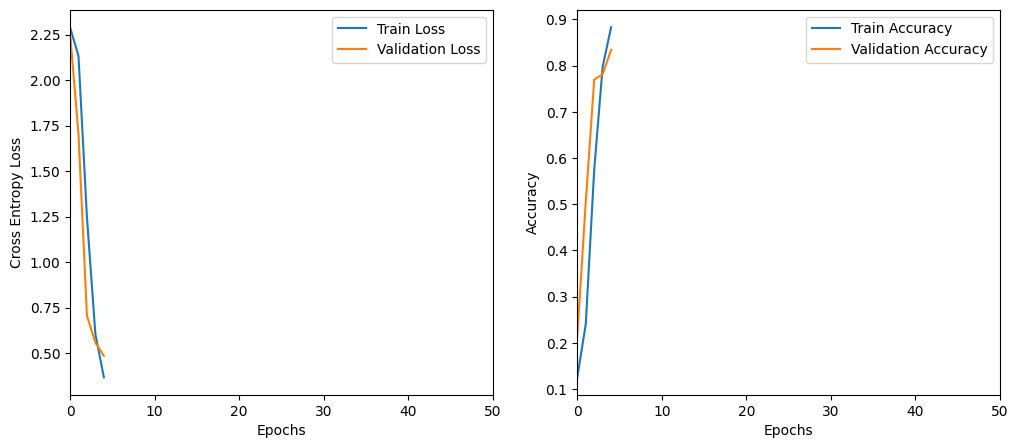


Epoch 6 of 50 started...
Epoch 6 of 50 (12:42) - Train loss: 0.25785 - Train acc: 0.92288 - Val loss: 0.52644 - Val acc: 0.82540
Early Stopping Counter 1 of 5

Epoch 7 of 50 started...
Epoch 7 of 50 (12:45) - Train loss: 0.19249 - Train acc: 0.94270 - Val loss: 0.45996 - Val acc: 0.85215
Saving model with new best val_loss: 0.45996
Early Stopping Counter Reset

Epoch 8 of 50 started...
Epoch 8 of 50 (12:47) - Train loss: 0.15588 - Train acc: 0.95455 - Val loss: 0.45899 - Val acc: 0.83932
Saving model with new best val_loss: 0.45899

Epoch 9 of 50 started...
Epoch 9 of 50 (12:47) - Train loss: 0.13052 - Train acc: 0.96071 - Val loss: 0.46697 - Val acc: 0.83311

Epoch 10 of 50 started...
Epoch 10 of 50 (12:47) - Train loss: 0.11607 - Train acc: 0.96483 - Val loss: 0.43517 - Val acc: 0.85907
Saving model with new best val_loss: 0.43517


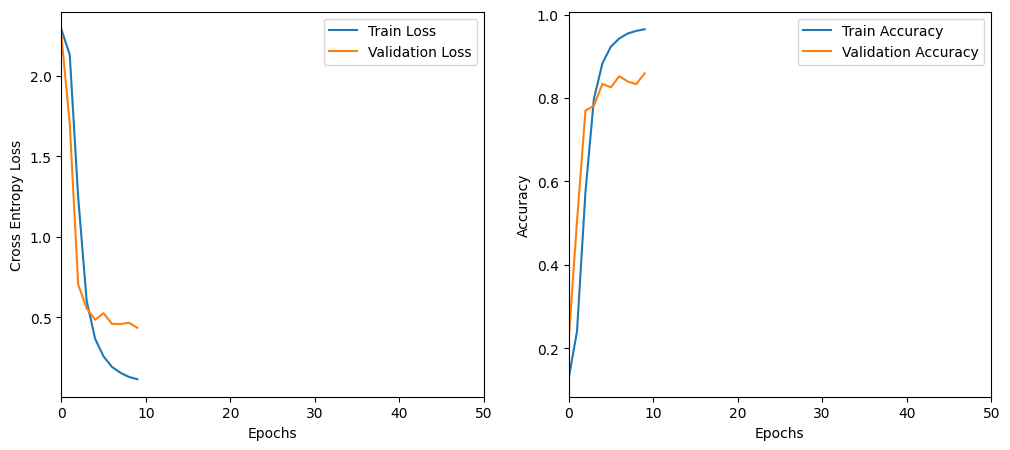


Epoch 11 of 50 started...
Epoch 11 of 50 (12:45) - Train loss: 0.09652 - Train acc: 0.97159 - Val loss: 0.52067 - Val acc: 0.85182
Early Stopping Counter 1 of 5

Epoch 12 of 50 started...
Epoch 12 of 50 (12:47) - Train loss: 0.09253 - Train acc: 0.97439 - Val loss: 0.48229 - Val acc: 0.85089
Early Stopping Counter 2 of 5

Epoch 13 of 50 started...
Epoch 13 of 50 (12:45) - Train loss: 0.07627 - Train acc: 0.97793 - Val loss: 0.53841 - Val acc: 0.84464
Early Stopping Counter 3 of 5

Epoch 14 of 50 started...
Epoch 14 of 50 (12:45) - Train loss: 0.07445 - Train acc: 0.97928 - Val loss: 0.42774 - Val acc: 0.86521
Saving model with new best val_loss: 0.42774
Early Stopping Counter Reset

Epoch 15 of 50 started...
Epoch 15 of 50 (12:46) - Train loss: 0.06399 - Train acc: 0.98254 - Val loss: 0.43634 - Val acc: 0.86224


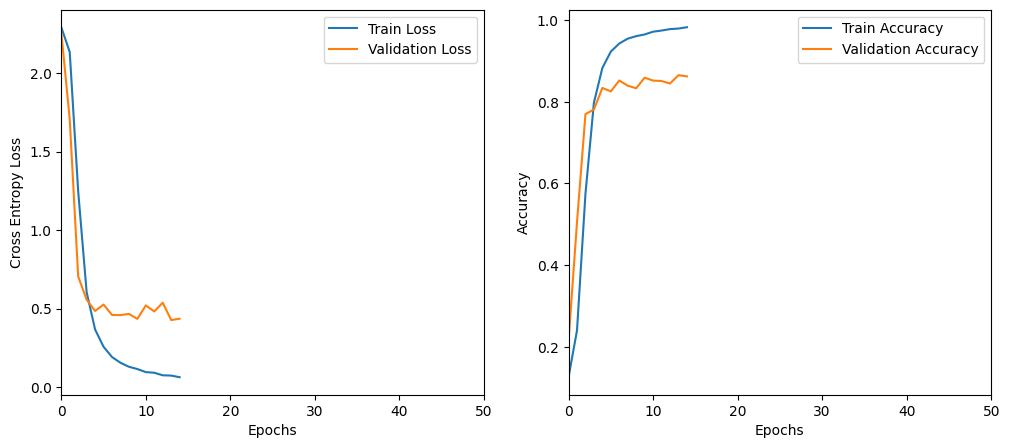


Epoch 16 of 50 started...
Epoch 16 of 50 (12:45) - Train loss: 0.06217 - Train acc: 0.98202 - Val loss: 0.43580 - Val acc: 0.85546

Epoch 17 of 50 started...
Epoch 17 of 50 (12:46) - Train loss: 0.05851 - Train acc: 0.98524 - Val loss: 0.46134 - Val acc: 0.85364
Early Stopping Counter 1 of 5

Epoch 18 of 50 started...
Epoch 18 of 50 (12:44) - Train loss: 0.05287 - Train acc: 0.98379 - Val loss: 0.55997 - Val acc: 0.84494
Early Stopping Counter 2 of 5

Epoch 19 of 50 started...
Epoch 19 of 50 (12:47) - Train loss: 0.05209 - Train acc: 0.98628 - Val loss: 0.42360 - Val acc: 0.87243
Saving model with new best val_loss: 0.42360
Early Stopping Counter Reset

Epoch 20 of 50 started...
Epoch 20 of 50 (12:49) - Train loss: 0.04782 - Train acc: 0.98583 - Val loss: 0.45997 - Val acc: 0.85546


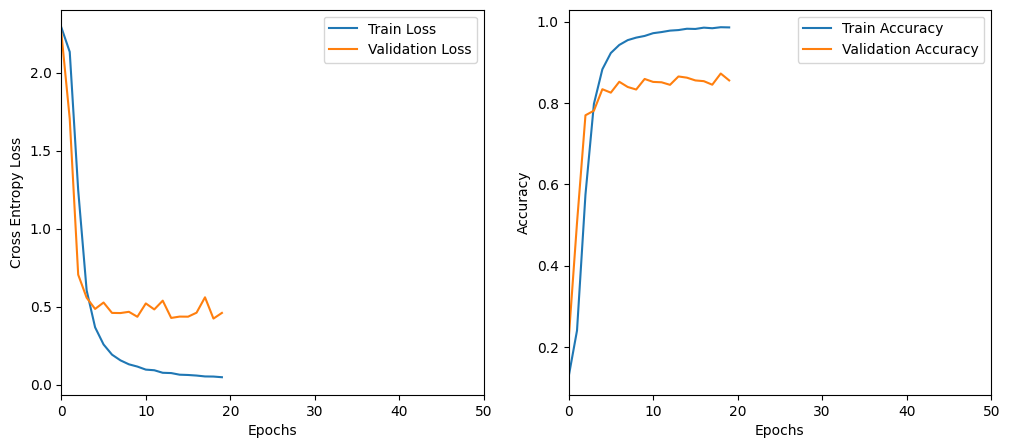

Early Stopping Counter 1 of 5

Epoch 21 of 50 started...
Epoch 21 of 50 (12:42) - Train loss: 0.04445 - Train acc: 0.98787 - Val loss: 0.48548 - Val acc: 0.84977
Early Stopping Counter 2 of 5

Epoch 22 of 50 started...
Epoch 22 of 50 (12:44) - Train loss: 0.04227 - Train acc: 0.98739 - Val loss: 0.47723 - Val acc: 0.86495
Early Stopping Counter 3 of 5

Epoch 23 of 50 started...
Epoch 23 of 50 (12:49) - Train loss: 0.04083 - Train acc: 0.98912 - Val loss: 0.44586 - Val acc: 0.86231

Epoch 24 of 50 started...
Epoch 24 of 50 (12:54) - Train loss: 0.03847 - Train acc: 0.98954 - Val loss: 0.52108 - Val acc: 0.84709
Early Stopping Counter 4 of 5

Epoch 25 of 50 started...
Epoch 00025: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00025: reducing learning rate of group 1 to 5.0000e-05.
Epoch 00025: reducing learning rate of group 2 to 1.0000e-04.
Epoch 25 of 50 (12:55) - Train loss: 0.03279 - Train acc: 0.99106 - Val loss: 0.56410 - Val acc: 0.85569


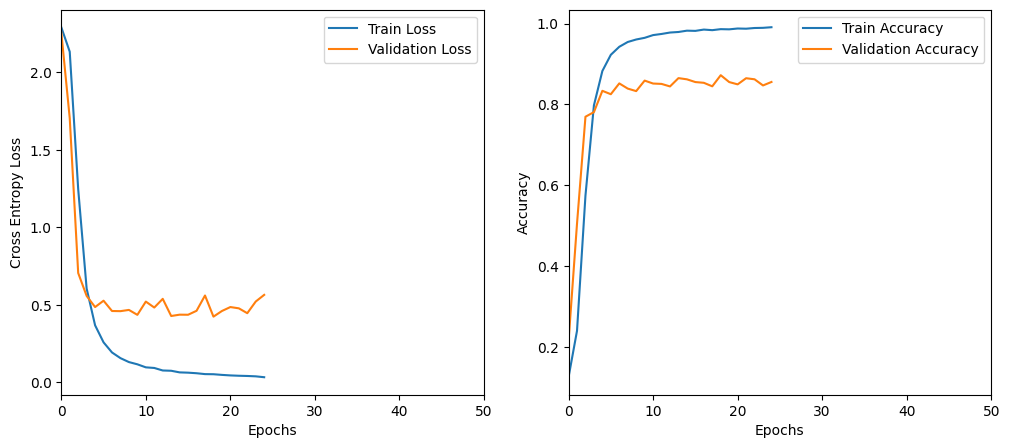

Early Stopping Counter 5 of 5
Epoch 25 of 50 - Early stopping
Saving final model, with loss:  0.5641035427649815


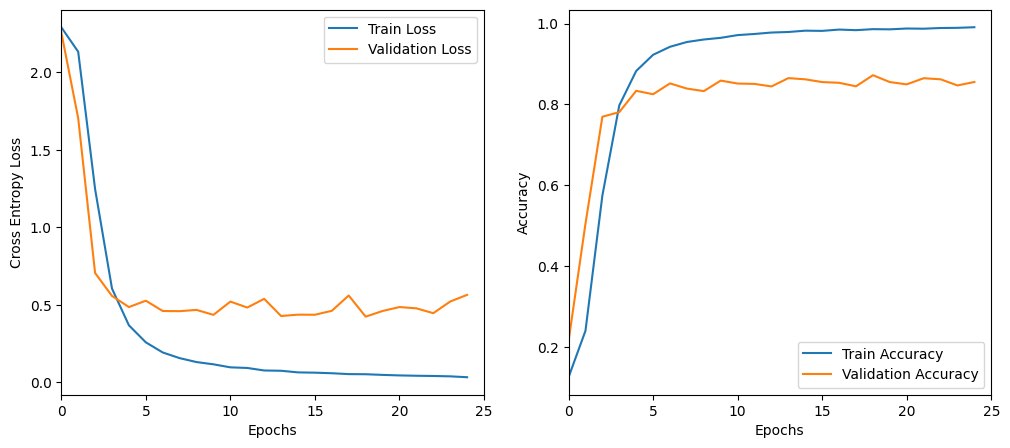

Total training time: 330:14


In [32]:
# Set device
MODEL_NAME = 'VGG16_v2'
model = net.to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9, weight_decay=0.01)

# scheduler + early stopping
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       'min',
                                                       factor=.1,
                                                       patience=5,
                                                       min_lr=1e-7,
                                                       verbose=True)

early_stopping = EarlyStopper(patience=5, min_delta=.03)

batch_size = config['modeling_params']['batch_size']
epochs = 50 

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# results
results = train(model=model,
                train_dataloader=train_dataloader,
                validation_dataloader=val_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device,
                scheduler=scheduler,
                early_stopping=early_stopping,
                model_name=MODEL_NAME)